In [1]:
import numpy as np 
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical ,load_img
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import random 
import os 

2023-09-25 15:13:26.438228: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-25 15:13:26.837997: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-25 15:13:28.549148: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Define constants: 
FAST_RUN = False 
IMAGE_WIDTH = 128 
IMAGE_HEIGHT = 128 
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT) 
IMAGE_CHANNELS = 3 

### Preparing Training Files

In [3]:
filenames = os.listdir("/home/shilpi_fire/Documents/Kaggle/10. Real_Fake_Image_detection/training_") 
print(len(filenames))
#considering the 'train' folder 
categories = [] 
real_fake = []
difficulty = []
image_id = []
left_eye_fake = [] 
right_eye_fake = [] 
nose_fake = []
mouth_fake = []
for filename in filenames:
    real_or_fake = filename.split('_')[0] 
    if(real_or_fake == 'real'): 
        pass 
        real_fake.append(0)
        difficulty.append(0) #not difficult at all as img is real. 
        # image_id.append(filename.split('_')[1])
        image_id.append(filename)
        left_eye_fake.append(0) 
        right_eye_fake.append(0)
        nose_fake.append(0) 
        mouth_fake.append(0)
    else: 
        real_fake.append(1)
        if(real_or_fake== 'easy'): 
            difficulty.append(1)
        elif(real_or_fake == 'mid'): 
            difficulty.append(2) 
        else: 
            difficulty.append(3)
        # difficulty.append(real_or_fake )
        # image_id.append(filename.split('_')[1])
        image_id.append(filename) #dont' think this column wud be particularly useful
        left_eye_fake.append(filename.split('_')[2][0])
        right_eye_fake.append(filename.split('_')[2][1])
        nose_fake.append(filename.split('_')[2][2])
        mouth_fake.append((filename.split('_')[2][3]))

df = pd.DataFrame({ 
    'Real_Fake': real_fake,  #this'll be 1/0
    'Difficulty': difficulty,
    'Id': image_id, 
    'Left_Eye_Fake': left_eye_fake, 
    'Right_Eye_Fake': right_eye_fake, 
    'Nose_Fake': nose_fake, 
    'Mouth_Fake': mouth_fake, 
})
df.head(3)

2040


,Real_Fake,Difficulty,Id,Left_Eye_Fake,Right_Eye_Fake,Nose_Fake,Mouth_Fake
0,0,0,real_00367.jpg,0,0,0,0
1,0,0,real_00919.jpg,0,0,0,0
2,1,2,mid_328_0011.jpg,0,0,1,1


In [4]:
df.to_csv("metadata.csv", index=False)

In [5]:
train_df = pd.read_csv('/home/shilpi_fire/Documents/Kaggle/10. Real_Fake_Image_detection/metadata.csv', index_col='Id')
train_df.head(5)

,Real_Fake,Difficulty,Left_Eye_Fake,Right_Eye_Fake,Nose_Fake,Mouth_Fake
Id,,,,,,
real_00367.jpg,0,0,0,0,0,0
real_00919.jpg,0,0,0,0,0,0
mid_328_0011.jpg,1,2,0,0,1,1
mid_334_1111.jpg,1,2,1,1,1,1
real_00240.jpg,0,0,0,0,0,0


In [6]:
temp = train_df.sort_values('Id')
temp.head(4)

,Real_Fake,Difficulty,Left_Eye_Fake,Right_Eye_Fake,Nose_Fake,Mouth_Fake
Id,,,,,,
easy_100_1111.jpg,1,1,1,1,1,1
easy_101_0010.jpg,1,1,0,0,1,0
easy_102_0101.jpg,1,1,0,1,0,1
easy_103_1111.jpg,1,1,1,1,1,1


In [7]:
train_df.shape


(2040, 6)

In [8]:
train_df.dtypes
# print(train_df['Mouth_Fake'].value_counts())

Real_Fake         int64
Difficulty        int64
Left_Eye_Fake     int64
Right_Eye_Fake    int64
Nose_Fake         int64
Mouth_Fake        int64
dtype: object

### Preprocessing Images

Found 2040 images belonging to 2 classes.


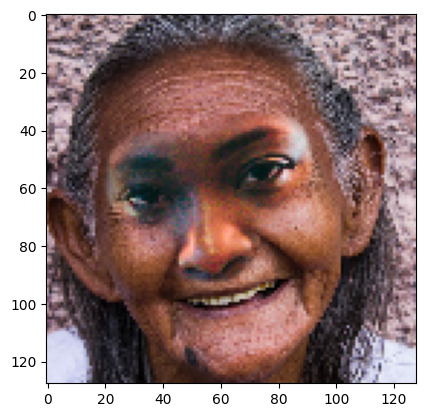

(128, 128, 3)
float32


In [9]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0  # Normalize pixel values to [0,1]
    # ... (any other augmentations)
)

# Create a data generator for the training images
train_generator = train_datagen.flow_from_directory(
    '/home/shilpi_fire/Documents/Kaggle/10. Real_Fake_Image_detection/training_real_fake',
    target_size=IMAGE_SIZE,  # Resizing
    batch_size=32,
    class_mode='binary'  # Or 'binary' depending on your problem
)


# Get a single batch of images and labels from the generator
images, labels = next(train_generator)

# Show the first image from the batch
plt.imshow(images[0])
plt.show()

# Check the shape and type of the image array
print(images[0].shape)
print(images[0].dtype)

## Training on just Images (Not including Tabular data)

real_00292.jpg


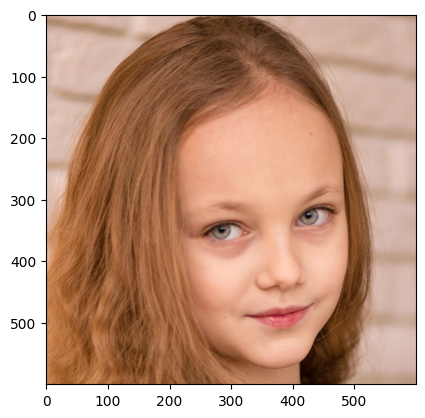

In [10]:
#see sample image : 
import random 
sample = random.choice(filenames) 
print(sample)
image = load_img("/home/shilpi_fire/Documents/Kaggle/10. Real_Fake_Image_detection/training_/" + sample)
plt.imshow(image) 

### Defining Model

In [11]:
#come back and try adding one more dense layer with relu activation 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten ,Dense, Activation, BatchNormalization 

model = Sequential()
#first para is #filters, then kernel_size(dimn of filter) 
model.add(Conv2D(32, (3,3),activation = 'relu', input_shape = (128, 128, 3)))#these r defined above as IMAGE_WIDTH..
model.add(BatchNormalization()) 
model.add(MaxPooling2D(pool_size = (2,2))) 
model.add(Dropout(0.25)) 

#2nd hidden layer 
model.add(Conv2D(64, (3,3), activation = 'relu')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2))) 
model.add(Dropout(0.25)) 

#3rd hidden layer . 
model.add(Conv2D(512, (3,3), activation = 'relu')) 
model.add(BatchNormalization()) 
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dropout(0.25)) 

#4th layer : output layer
model.add(Flatten()) 
model.add(Dense(12, activation = 'relu')) 
model.add(BatchNormalization()) 
model.add(Dense(1, activation = 'sigmoid')) 
#using 2 dense layers is more advised as compared to using a single dense layer. 
#dense layer is used in the last stages. 

# model.compile(loss = 'categorical_crossentropy' ,optimizer = 'rmsprop', metrics = ['accuracy'])  
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#categorical_crossentropy used when true labels are one-hot encoded
#wonder why we're not using adam as optimizer

model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

### Callbacks

In [12]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau 
earlystop = EarlyStopping(patience = 10) 
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 2, 
    verbose = 1, #this means that only 1 metric will be showed, verbose = 0 implies bunch of parameters wouldn't be printed.
    factor = 0.5, #factpr by which the lr will be reduced. 
    min_lr = 0.00001
)
callbacks = [ earlystop, learning_rate_reduction] 

### Prepare Data

In [13]:
# df = train_df['Real_Fake']
df = train_df.reset_index()[['Id', 'Real_Fake']]
df.head(3)

,Id,Real_Fake
0,real_00367.jpg,0
1,real_00919.jpg,0
2,mid_328_0011.jpg,1


In [14]:
from sklearn.model_selection import train_test_split 
df['Real_Fake'] = df['Real_Fake'].replace({0:'real', 1:'fake'}) 

train_df, validate_df = train_test_split(df, test_size = 0.2, random_state = 42)
print('this is train_df, validate_df.shape', train_df.shape, validate_df.shape) 
train_df = train_df.reset_index(drop = True)   
validate_df = validate_df.reset_index(drop = True) 

this is train_df, validate_df.shape (1632, 2) (408, 2)


In [15]:
print(df.shape, train_df.shape) 
print('len(train_df) + len(validate_df) = len(df)\n',len(train_df),' + ',len(validate_df),' -> ', len(df))

(2040, 2) (1632, 2)
len(train_df) + len(validate_df) = len(df)
 1632  +  408  ->  2040


In [16]:
total_train = train_df.shape[0] #this is basically len(train_df)
total_validate = validate_df.shape[0] #total no. of examples in validation set 
batch_size = 15 

In [17]:
#Train Generator: 
train_datagen = ImageDataGenerator( 
    rotation_range = 15, #the range in degrees by which an image is allowed to be rotated. 
    rescale = 1./255 , #values after all transformations are multiplied by this
    shear_range = 0.1, #this is angle in degrees, refers to the angle by which all the ponints are moved.
    zoom_range = 0.2, 
    horizontal_flip = True, 
    width_shift_range = 0.1, 
    height_shift_range = 0.1
)
#The flow_from_dataframe() method takes the Pandas DataFrame and the path to a directory and generates batches of augmented/normalized data.
train_generator = train_datagen.flow_from_dataframe(#used for augmentation
    train_df, #dataframe
    "/home/shilpi_fire/Documents/Kaggle/10. Real_Fake_Image_detection/training_/", #directory
    x_col = 'Id', 
    y_col = 'Real_Fake', 
    target_size = (128 ,128), #its defined above as IMAGE_SIZE
    class_mode = 'categorical', 
    batch_size = 15 #defined above as 15. 
)

Found 1632 validated image filenames belonging to 2 classes.


In [18]:
#Validation Generator 
validation_datagen = ImageDataGenerator(rescale = 1./255) 
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/home/shilpi_fire/Documents/Kaggle/10. Real_Fake_Image_detection/training_/", 
    x_col = 'Id', 
    y_col = 'Real_Fake', 
    target_size = (128 ,128), #its defined above, 
    class_mode = 'categorical', 
    batch_size = 15
)

Found 408 validated image filenames belonging to 2 classes.


In [19]:
#Checking the working of our generator 
example_df = train_df.sample(n = 1).reset_index(drop = True)  
#setting n = 2 would give 2 different images...and their various augmneted
example_generator = train_datagen.flow_from_dataframe(
    example_df, #contains just 1 file
    "/home/shilpi_fire/Documents/Kaggle/10. Real_Fake_Image_detection/training_/", 
    x_col = 'Id', 
    y_col = 'Real_Fake', 
    target_size = (128 ,128), #its defined above, 
    class_mode = 'categorical'
)

Found 1 validated image filenames belonging to 1 classes.


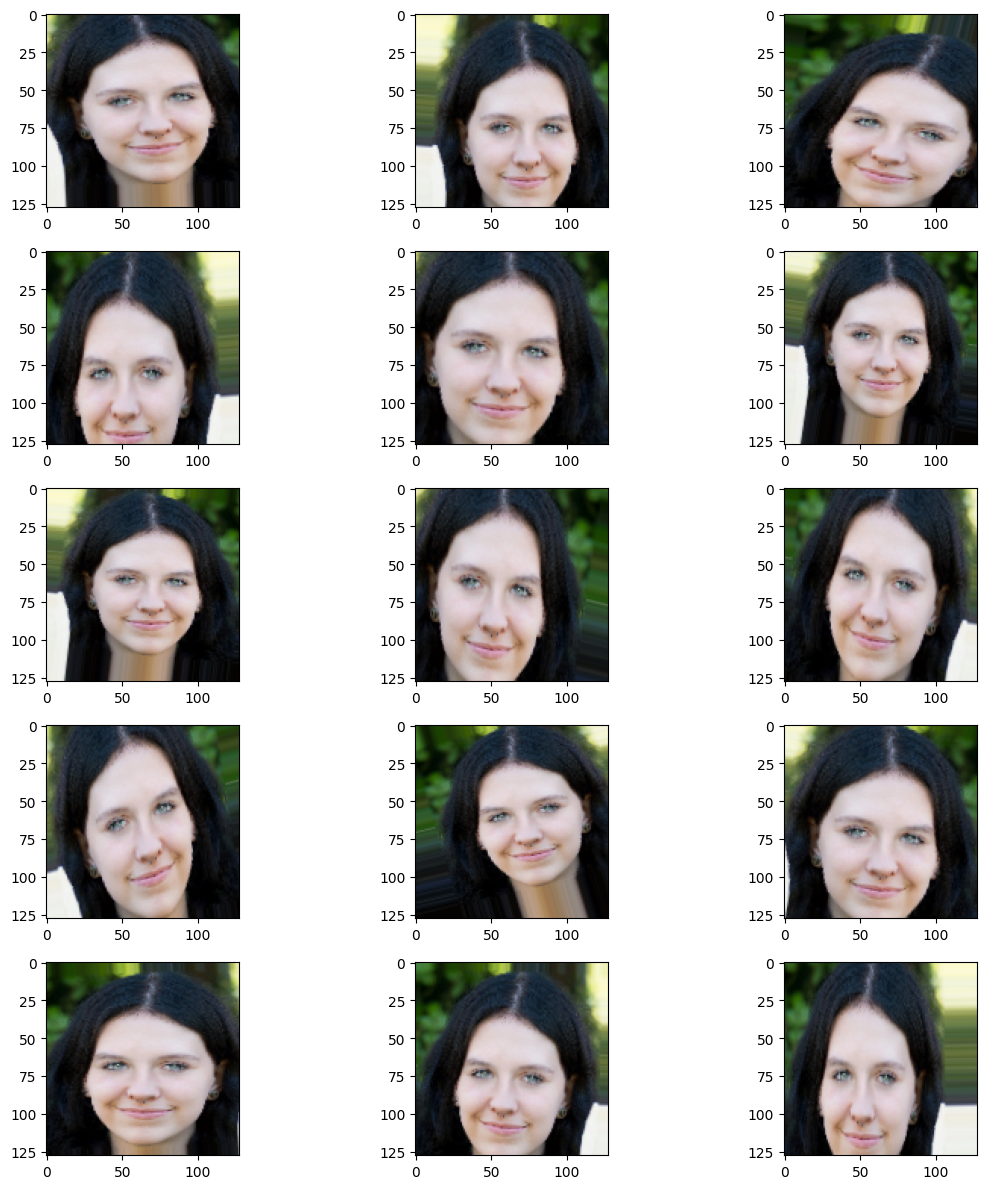

In [20]:
plt.figure(figsize = (12,12)) 
for i in range(0,15):
  plt.subplot(5, 3, i+1) 
  for x_batch, y_batch in example_generator:
    image = x_batch[0]
    plt.imshow(image) 
    break 
plt.tight_layout() 
plt.show() 
#for n = 2, there'd be 15 augmented images of 2 images, like 7 of one, 8 of other

In [21]:
print(total_train) 
print(total_train//batch_size)
print(total_validate) 
print(total_validate // batch_size)

1632
108
408
27


### Fit Model

In [22]:
epochs = 3 
history = model.fit_generator(
    train_generator , 
    epochs = epochs , 
    validation_data = validation_generator , 
    validation_steps = total_validate//batch_size, #total_validate: no. of examples in validation set
    steps_per_epoch = total_train //batch_size , 
    callbacks = callbacks   #there are 2 callbacks 
)

/tmp/ipykernel_115341/4148552537.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/3


2023-09-25 15:13:42.068004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-09-25 15:13:44.933315: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 30481920 exceeds 10% of free system memory.
2023-09-25 15:13:45.037131: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 30481920 exceeds 10% of free system memory.
2023-09-25 15:13:45.132987: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 14288640 exceeds 10% of free system memory.
2023-09-25 15:13:45.206181: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 14288640 exceeds 10% of free system memory.
2023-09-25 15:13:45.260888: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24084480 exceeds 10% of

108/108 [==============================] - ETA: 0s - loss: 0.7071 - accuracy: 0.5000

2023-09-25 15:19:41.373516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


108/108 [==============================] - 383s 4s/step - loss: 0.7071 - accuracy: 0.5000 - val_loss: 0.8903 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/3
108/108 [==============================] - 366s 3s/step - loss: 0.6996 - accuracy: 0.5000 - val_loss: 0.6976 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/3
108/108 [==============================] - ETA: 0s - loss: 0.6948 - accuracy: 0.5000
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
108/108 [==============================] - 352s 3s/step - loss: 0.6948 - accuracy: 0.5000 - val_loss: 0.7061 - val_accuracy: 0.5000 - lr: 0.0010


In [23]:
#Save model 
model.save_weights("model.h5")

### Prepare your own Data to Test

In [24]:
test_filenames = os.listdir("/home/shilpi_fire/Documents/Kaggle/10. Real_Fake_Image_detection/to_test_")
test_df = pd.DataFrame({
    'Id' :test_filenames
})
nb_samples = test_df.shape[0] #this is basically len(test_files)
test_df = test_df.drop_duplicates(subset='Id', keep='first')
print(test_df.shape)

(1, 1)


Found 1 validated image filenames.


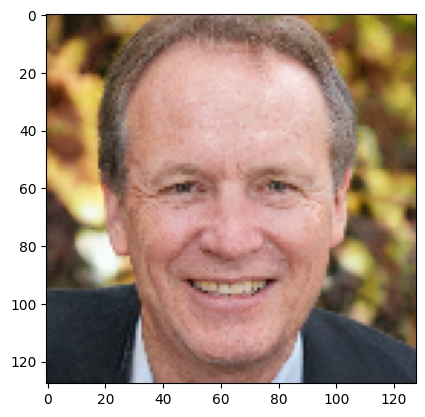

(128, 128, 3)
float32


In [26]:
#Create Test Generator
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/home/shilpi_fire/Documents/Kaggle/10. Real_Fake_Image_detection/to_test_",
    x_col = 'Id', 
    y_col = None, 
    class_mode = None, 
    target_size = IMAGE_SIZE, #this is probably(28, 28) 
    batch_size = batch_size, 
    shuffle = False 
)

# Get a single batch of images and labels from the generator
images = next(test_generator)

# Show the first image from the batch
plt.imshow(images[0])
plt.show()

# Check the shape and type of the image array
print(images[0].shape)
print(images[0].dtype)

In [27]:
# Using predict instead of predict_generator as it's deprecated in newer versions
predict = model.predict(test_generator, steps=np.ceil(nb_samples / batch_size))

# Threshold the predictions to get binary labels
test_df['category'] = (predict > 0.5).astype(int).flatten()

# Map back to 'real' and 'fake'
test_df['category'] = test_df['category'].replace({0: 'real', 1: 'fake'})


2023-09-25 15:32:07.396197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 2s 2s/step


In [28]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items()) 
test_df['category'] = test_df['category'].replace(label_map) 

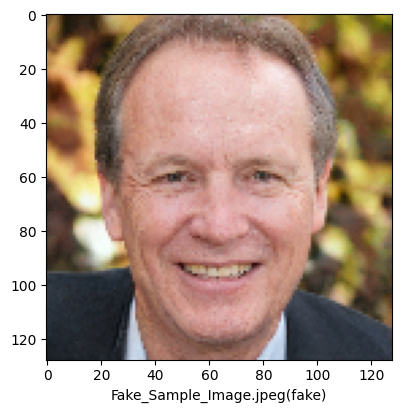

In [29]:
#See predicted result with images
sample_test = test_df.head(18) 
sample_test.head() 
plt.figure(figsize = (12,24))  
for index, row in sample_test.iterrows(): 
  filename = row['Id'] 
  category = row['category']
  img = load_img("/home/shilpi_fire/Documents/Kaggle/10. Real_Fake_Image_detection/to_test_/"+ filename, target_size = IMAGE_SIZE)
  plt.subplot(6, 3, index+1) 
  plt.imshow(img) 
  plt.xlabel(filename+ '(' + "{}".format(category)+ ')')
plt.tight_layout() 
plt.show() 